# MNIST Dataset Loading and Visualization

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import os

# Path to MNIST dataset
MNIST_PATH = "./dataset/MNIST"

In [5]:
def load_mnist_images(filename):
    """
    Load MNIST images from IDX format file.
    Returns images as numpy array of shape (num_images, 28, 28)
    """
    with open(filename, 'rb') as f:
        # Read magic number and dimensions
        magic = struct.unpack('>I', f.read(4))[0]
        num_images = struct.unpack('>I', f.read(4))[0]
        num_rows = struct.unpack('>I', f.read(4))[0]
        num_cols = struct.unpack('>I', f.read(4))[0]
        
        # Read image data
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)
        return images

def load_mnist_labels(filename):
    """
    Load MNIST labels from IDX format file.
    Returns labels as numpy array of shape (num_labels,)
    """
    with open(filename, 'rb') as f:
        # Read magic number and number of labels
        magic = struct.unpack('>I', f.read(4))[0]
        num_labels = struct.unpack('>I', f.read(4))[0]
        
        # Read label data
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

In [6]:
# Load all MNIST data
print("Loading MNIST dataset...")

# Training data
train_images = load_mnist_images(os.path.join(MNIST_PATH, "train-images.idx3-ubyte"))
train_labels = load_mnist_labels(os.path.join(MNIST_PATH, "train-labels.idx1-ubyte"))

# Test data
test_images = load_mnist_images(os.path.join(MNIST_PATH, "t10k-images.idx3-ubyte"))
test_labels = load_mnist_labels(os.path.join(MNIST_PATH, "t10k-labels.idx1-ubyte"))

print(f"✓ Training data loaded: {train_images.shape} images, {train_labels.shape} labels")
print(f"✓ Test data loaded: {test_images.shape} images, {test_labels.shape} labels")

Loading MNIST dataset...
✓ Training data loaded: (60000, 28, 28) images, (60000,) labels
✓ Test data loaded: (10000, 28, 28) images, (10000,) labels


## Visualizing Sample Images

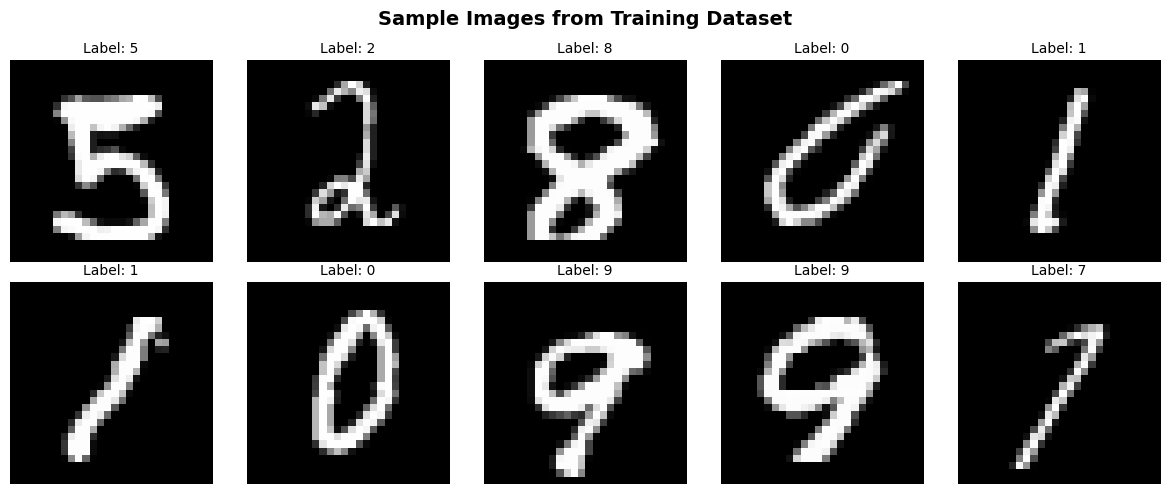

In [7]:
# Display 10 random training images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Sample Images from Training Dataset", fontsize=14, fontweight='bold')

# Get 10 random indices
random_indices = np.random.choice(len(train_images), 10, replace=False)

for idx, ax in enumerate(axes.flat):
    img_idx = random_indices[idx]
    ax.imshow(train_images[img_idx], cmap='gray')
    ax.set_title(f"Label: {train_labels[img_idx]}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Display statistics about the dataset
print("=" * 50)
print("MNIST DATASET STATISTICS")
print("=" * 50)

print(f"\nTraining Data:")
print(f"  - Images shape: {train_images.shape}")
print(f"  - Labels shape: {train_labels.shape}")
print(f"  - Image range: [{train_images.min()}, {train_images.max()}]")
print(f"  - Unique classes: {np.unique(train_labels)}")
print(f"  - Class distribution:")
for digit in range(10):
    count = np.sum(train_labels == digit)
    percentage = 100 * count / len(train_labels)
    print(f"    Digit {digit}: {count:6d} images ({percentage:5.1f}%)")

print(f"\nTest Data:")
print(f"  - Images shape: {test_images.shape}")
print(f"  - Labels shape: {test_labels.shape}")
print(f"  - Image range: [{test_images.min()}, {test_images.max()}]")
print(f"  - Class distribution:")
for digit in range(10):
    count = np.sum(test_labels == digit)
    percentage = 100 * count / len(test_labels)
    print(f"    Digit {digit}: {count:6d} images ({percentage:5.1f}%)")

MNIST DATASET STATISTICS

Training Data:
  - Images shape: (60000, 28, 28)
  - Labels shape: (60000,)
  - Image range: [0, 255]
  - Unique classes: [0 1 2 3 4 5 6 7 8 9]
  - Class distribution:
    Digit 0:   5923 images (  9.9%)
    Digit 1:   6742 images ( 11.2%)
    Digit 2:   5958 images (  9.9%)
    Digit 3:   6131 images ( 10.2%)
    Digit 4:   5842 images (  9.7%)
    Digit 5:   5421 images (  9.0%)
    Digit 6:   5918 images (  9.9%)
    Digit 7:   6265 images ( 10.4%)
    Digit 8:   5851 images (  9.8%)
    Digit 9:   5949 images (  9.9%)

Test Data:
  - Images shape: (10000, 28, 28)
  - Labels shape: (10000,)
  - Image range: [0, 255]
  - Class distribution:
    Digit 0:    980 images (  9.8%)
    Digit 1:   1135 images ( 11.3%)
    Digit 2:   1032 images ( 10.3%)
    Digit 3:   1010 images ( 10.1%)
    Digit 4:    982 images (  9.8%)
    Digit 5:    892 images (  8.9%)
    Digit 6:    958 images (  9.6%)
    Digit 7:   1028 images ( 10.3%)
    Digit 8:    974 images (  9.7%)

## Training MLP with scikit-learn and 5-Fold Cross-Validation

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import time

# Prepare data: flatten images for MLP
X_train = train_images.reshape(train_images.shape[0], -1)
X_test = test_images.reshape(test_images.shape[0], -1)
y_train = train_labels
y_test = test_labels

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Data prepared for MLP:")
print(f"  - Training data shape: {X_train.shape}")
print(f"  - Test data shape: {X_test.shape}")

Data prepared for MLP:
  - Training data shape: (60000, 784)
  - Test data shape: (10000, 784)


In [10]:
# Setup 5-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define MLP model
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    max_iter=300,
    batch_size=128,
    learning_rate_init=0.001,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=0
)

print("\nMLP Configuration:")
print(f"  - Hidden layers: {mlp.hidden_layer_sizes}")
print(f"  - Activation: {mlp.activation}")
print(f"  - Max iterations: {mlp.max_iter}")
print(f"  - Learning rate: {mlp.learning_rate_init}")
print(f"  - Early stopping: {mlp.early_stopping}")


MLP Configuration:
  - Hidden layers: (256, 128)
  - Activation: relu
  - Max iterations: 300
  - Learning rate: 0.001
  - Early stopping: True


In [11]:
# Perform 5-Fold Cross-Validation
print("\n" + "="*70)
print("5-FOLD CROSS-VALIDATION ON TRAINING DATA")
print("="*70 + "\n")

scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

start_time = time.time()
cv_results = cross_validate(mlp, X_train, y_train, cv=kfold, scoring=scoring, return_train_score=True)
cv_time = time.time() - start_time

# Extract and display results
print(f"Cross-validation completed in {cv_time:.2f} seconds\n")

print("Test Set Metrics (from CV):")
print(f"  - Accuracy:        {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
print(f"  - Precision (macro): {cv_results['test_precision_macro'].mean():.4f} (+/- {cv_results['test_precision_macro'].std():.4f})")
print(f"  - Recall (macro):    {cv_results['test_recall_macro'].mean():.4f} (+/- {cv_results['test_recall_macro'].std():.4f})")
print(f"  - F1-Score (macro):  {cv_results['test_f1_macro'].mean():.4f} (+/- {cv_results['test_f1_macro'].std():.4f})")

print("\nTrain Set Metrics (from CV):")
print(f"  - Accuracy:        {cv_results['train_accuracy'].mean():.4f} (+/- {cv_results['train_accuracy'].std():.4f})")
print(f"  - Precision (macro): {cv_results['train_precision_macro'].mean():.4f} (+/- {cv_results['train_precision_macro'].std():.4f})")
print(f"  - Recall (macro):    {cv_results['train_recall_macro'].mean():.4f} (+/- {cv_results['train_recall_macro'].std():.4f})")
print(f"  - F1-Score (macro):  {cv_results['train_f1_macro'].mean():.4f} (+/- {cv_results['train_f1_macro'].std():.4f})")

print("\nIndividual Fold Results:")
for fold in range(5):
    print(f"  Fold {fold+1} - Test Accuracy: {cv_results['test_accuracy'][fold]:.4f}, Train Accuracy: {cv_results['train_accuracy'][fold]:.4f}")


5-FOLD CROSS-VALIDATION ON TRAINING DATA

Cross-validation completed in 355.27 seconds

Test Set Metrics (from CV):
  - Accuracy:        0.9789 (+/- 0.0016)
  - Precision (macro): 0.9788 (+/- 0.0016)
  - Recall (macro):    0.9788 (+/- 0.0017)
  - F1-Score (macro):  0.9788 (+/- 0.0016)

Train Set Metrics (from CV):
  - Accuracy:        0.9972 (+/- 0.0009)
  - Precision (macro): 0.9972 (+/- 0.0009)
  - Recall (macro):    0.9972 (+/- 0.0009)
  - F1-Score (macro):  0.9972 (+/- 0.0009)

Individual Fold Results:
  Fold 1 - Test Accuracy: 0.9792, Train Accuracy: 0.9966
  Fold 2 - Test Accuracy: 0.9816, Train Accuracy: 0.9986
  Fold 3 - Test Accuracy: 0.9767, Train Accuracy: 0.9958
  Fold 4 - Test Accuracy: 0.9792, Train Accuracy: 0.9975
  Fold 5 - Test Accuracy: 0.9780, Train Accuracy: 0.9975
Cross-validation completed in 355.27 seconds

Test Set Metrics (from CV):
  - Accuracy:        0.9789 (+/- 0.0016)
  - Precision (macro): 0.9788 (+/- 0.0016)
  - Recall (macro):    0.9788 (+/- 0.0017)
 

In [12]:
# Train final model on all training data for evaluation on test set
print("\n" + "="*70)
print("FINAL MODEL TRAINING AND TEST SET EVALUATION")
print("="*70 + "\n")

mlp_final = MLPClassifier(
    hidden_layer_sizes=(512, 256),
    activation='relu',
    max_iter=500,
    batch_size=128,
    learning_rate_init=0.001,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=0
)

print("Training final model on full training set...")
start_time = time.time()
mlp_final.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds\n")

# Evaluate on test set
y_pred = mlp_final.predict(X_test)
y_pred_train = mlp_final.predict(X_train)

print("TEST SET METRICS:")
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
test_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"  - Accuracy:        {test_accuracy:.4f}")
print(f"  - Precision (macro): {test_precision:.4f}")
print(f"  - Recall (macro):    {test_recall:.4f}")
print(f"  - F1-Score (macro):  {test_f1:.4f}")

print("\nTRAINING SET METRICS:")
train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train, average='macro', zero_division=0)
train_recall = recall_score(y_train, y_pred_train, average='macro', zero_division=0)
train_f1 = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

print(f"  - Accuracy:        {train_accuracy:.4f}")
print(f"  - Precision (macro): {train_precision:.4f}")
print(f"  - Recall (macro):    {train_recall:.4f}")
print(f"  - F1-Score (macro):  {train_f1:.4f}")


FINAL MODEL TRAINING AND TEST SET EVALUATION

Training final model on full training set...
Training completed in 156.61 seconds

Training completed in 156.61 seconds

TEST SET METRICS:
  - Accuracy:        0.9807
  - Precision (macro): 0.9808
  - Recall (macro):    0.9806
  - F1-Score (macro):  0.9807

TRAINING SET METRICS:
  - Accuracy:        0.9957
  - Precision (macro): 0.9957
  - Recall (macro):    0.9956
  - F1-Score (macro):  0.9957
TEST SET METRICS:
  - Accuracy:        0.9807
  - Precision (macro): 0.9808
  - Recall (macro):    0.9806
  - F1-Score (macro):  0.9807

TRAINING SET METRICS:
  - Accuracy:        0.9957
  - Precision (macro): 0.9957
  - Recall (macro):    0.9956
  - F1-Score (macro):  0.9957


In [13]:
# Detailed classification report on test set
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT (TEST SET)")
print("="*70 + "\n")
print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)]))


DETAILED CLASSIFICATION REPORT (TEST SET)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.98      0.99       892
           6       0.97      0.99      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.97      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



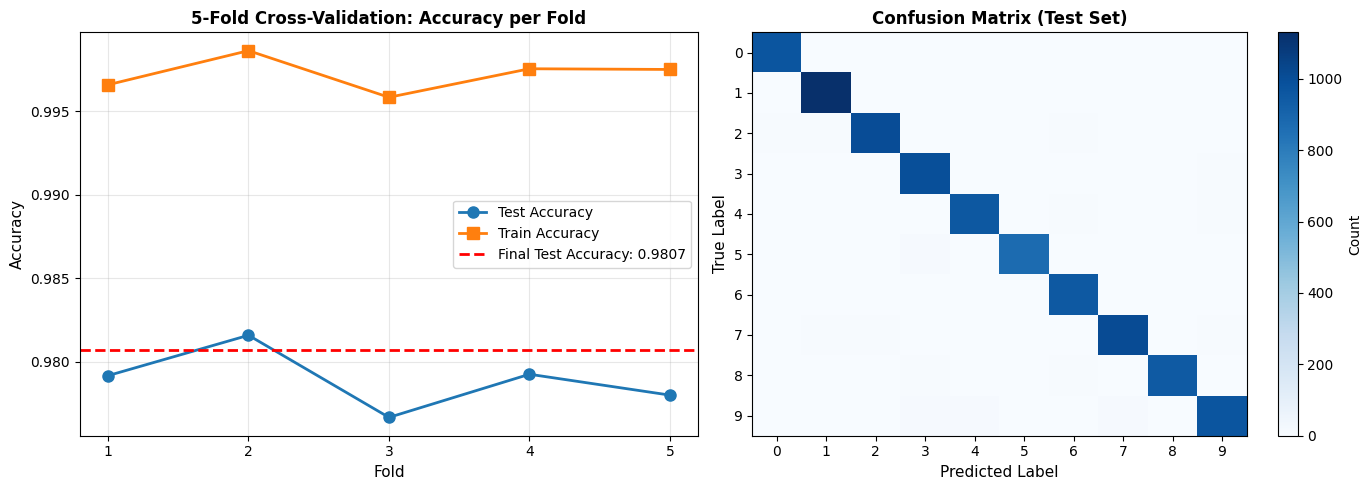


Confusion Matrix (Test Set):
[[ 971    2    1    1    1    0    3    1    0    0]
 [   0 1130    2    0    0    1    2    0    0    0]
 [   5    5 1003    3    2    0    6    4    4    0]
 [   0    0    3  996    0    1    0    2    2    6]
 [   2    1    2    1  957    0    7    3    2    7]
 [   2    0    0   12    1  873    3    0    1    0]
 [   0    2    0    1    2    1  951    0    1    0]
 [   2    5    5    0    0    0    0 1008    1    7]
 [   2    1    1    7    2    3    5    3  948    2]
 [   3    3    0    9    9    1    1   10    3  970]]


In [14]:
# Visualization of results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Cross-validation scores across folds
folds = np.arange(1, 6)
axes[0].plot(folds, cv_results['test_accuracy'], 'o-', label='Test Accuracy', linewidth=2, markersize=8)
axes[0].plot(folds, cv_results['train_accuracy'], 's-', label='Train Accuracy', linewidth=2, markersize=8)
axes[0].axhline(y=test_accuracy, color='r', linestyle='--', label=f'Final Test Accuracy: {test_accuracy:.4f}', linewidth=2)
axes[0].set_xlabel('Fold', fontsize=11)
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('5-Fold Cross-Validation: Accuracy per Fold', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(folds)

# Plot 2: Confusion matrix on test set
cm = confusion_matrix(y_test, y_pred)
im = axes[1].imshow(cm, cmap='Blues', aspect='auto')
axes[1].set_xlabel('Predicted Label', fontsize=11)
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_title('Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')
axes[1].set_xticks(np.arange(10))
axes[1].set_yticks(np.arange(10))

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label('Count', fontsize=10)

plt.tight_layout()
plt.show()

# Print confusion matrix
print("\nConfusion Matrix (Test Set):")
print(cm)